In [2]:
%matplotlib inline
import math
import time
import numpy as np
import torch 
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [3]:
# 记录运行时间
class Timer:
    def __init__(self):
        self.times = []
        self.start()
        
    def start(self):
        # 启动计时器
        self.tik = time.time()
        
    def stop(self):
        # 停止计时器并将时间记录在列表里
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        """返回平均时间"""
        return sum(self.times)/len(self.times)
    
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist() 

$$p(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{1}{2 \sigma^2}(x-\nu)^2}$$

In [4]:
# 正态分布和平方损失
def normal(x,mu,sigma):
    p = 1/math.sqrt(2*math.pi*sigma**2)
    return p * np.exp(-0.5/sigma**2*(x-mu)**2)

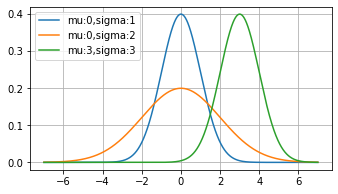

In [5]:
x = np.arange(-7,7,0.01)
params = [(0,1),(0,2),(3,1)]
y = [normal(x, mu, sigma) for mu, sigma in params]
fig = plt.figure(figsize = (5.4,3.0))
line1, = plt.plot(x,y[0],label = "mu:0,sigma:1")
line2, = plt.plot(x,y[1],label = "mu:0,sigma:2")
line3, = plt.plot(x,y[2],label = "mu:3,sigma:3")
plt.xlabel = "x"
plt.ylabel = "p(x)"
plt.grid(True)
plt.legend()

# 线性回归从零开始

In [6]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [7]:
def synthetic_data(w,b,num_examples):
    """生成y=Xw+b+噪声"""
    X = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(X,w) +b
    y += torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))


In [8]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:',features[0],'\nlabel',labels[0])

features: tensor([-1.4266,  0.3373]) 
label tensor([0.1897])


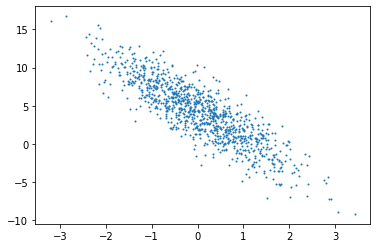

In [9]:
plt.scatter(features[:,1],labels,1)

In [10]:
# 生成数据迭代器
def data_iter(batch_size,features,labels):
    num_examples =len(features)
    indices= list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size,num_examples)])    # batch_indices是一个列表
        yield features[batch_indices],labels[batch_indices]

In [11]:
# 初始化参数模型
w = torch.normal(0,0.01,size=(2,1),requires_grad = True)
b = torch.zeros(1,requires_grad = True)

In [12]:
# 定义线性模型
def linreg(X,w,b):
    return torch.matmul(X, w) + b

# 定义损失函数
def squared_loss(y_hat,y):
    """均方误差"""
    return (y_hat - y.reshape(y_hat.shape))**2/2

#定义优化算法
def sgd(params, lr, batch_size):
    """小批量随机梯度下降法"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad/batch_size   # param.grad表示变量的梯度
            param.grad.zero_()

In [13]:
batch_size = 10
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
# 函数实例化时不需要加括号
# 进行训练
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y)   #X和y的小批量损失
        # 因为l的shape是(batch_size,1),而不是一个标量。l的所有元素被加到了一起
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w,b], lr, batch_size)    # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)                       # 计算损失的时候，把全部的数值都输入了进去
        print('epoch {}, loss {}'.format(epoch+1,train_l.mean()))

print("w的估计误差:",true_w - w.reshape(true_w.shape))
print("b的估计误差:",true_b - b)

epoch 1, loss 0.03821144998073578
epoch 2, loss 0.0001433663856005296
epoch 3, loss 4.900628482573666e-05
w的估计误差: tensor([-4.0507e-04,  4.5061e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)


# 线性模型的简介实现

In [14]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [15]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w,true_b,1000)
type(features),type(labels)

(torch.Tensor, torch.Tensor)

In [16]:
def load_array(data_arrays,batch_size, is_train = True):
    """构建一个Pytorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size,shuffle = is_train)

In [17]:
batch_size = 10
data_iter = load_array((features, labels),batch_size)
next(iter(data_iter))

[tensor([[ 0.6406,  0.4547],
         [-0.5956,  0.2733],
         [-0.3253, -0.1165],
         [-1.5368,  0.4915],
         [ 1.1908, -0.1366],
         [ 1.2889, -0.8130],
         [ 1.4217,  0.0551],
         [-0.1526,  2.0707],
         [-0.3369, -0.0023],
         [ 1.0668,  0.2599]]),
 tensor([[ 3.9369],
         [ 2.0784],
         [ 3.9477],
         [-0.5474],
         [ 7.0425],
         [ 9.5293],
         [ 6.8710],
         [-3.1583],
         [ 3.5455],
         [ 5.4519]])]

In [18]:
# 定义模型
"""
正如我们在构造nn.Linear时指定输⼊和输出尺⼨⼀样，现在我们能直接访问参数以设定它们的初始值。我
们通过net[0]选择⽹络中的第⼀个图层，然后使⽤weight.data和bias.data⽅法访问参数。我们还可
以使⽤替换⽅法normal_和fill_来重写参数值。
"""
from torch import nn
net = nn.Sequential(nn.Linear(2,1))
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0);

In [19]:
loss = nn.MSELoss()           # L2范数误差
trainer = torch.optim.SGD(net.parameters(),lr=0.03)
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X),y)       # 返回的时标量平均值
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features),labels)          # 计算损失时为全部的数据集输入，且回归问题使用L2范数
    print("epoch: {} loss: {}".format(epoch+1,l))

epoch: 1 loss: 0.00020724472415167838
epoch: 2 loss: 9.612207941245288e-05
epoch: 3 loss: 9.592319111106917e-05


In [20]:
w = net[0].weight.data
b = net[0].bias.data
print('w的误差：{}，b的误差：{}'.format(true_w-w.reshape(true_w.shape),true_b -b))

w的误差：tensor([ 4.9472e-05, -1.0014e-04])，b的误差：tensor([-9.2506e-05])


# softmax图像分类数据集

In [21]:
import torch
import torchvision                              # 读取数据集
from torch.utils import data                    # 生成数据集
from torchvision import transforms              # 图像预处理
from d2l import torch as d2l
import matplotlib.image as mpimg                # 图像可是化

In [22]:
mnist_train = torchvision.datasets.FashionMNIST(
    root ='../data',train=True,transform=transforms.ToTensor(),download=False)
mnist_test = torchvision.datasets.FashionMNIST(
    root ='../data',train=False,transform=transforms.ToTensor(),download=False)

In [23]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [24]:
def show_images(imgs,num_rows,num_cols,titles=None,scale=1.5):
    fig = plt.figure(figsize=(16,16))
    """绘制图像列表"""
    for i in range(len(imgs)):
        sp = plt.subplot(num_rows,num_cols,i+1)
        sp.axis('off')
        if titles:
            sp.set_title(titles[i])
        plt.imshow(imgs[i])

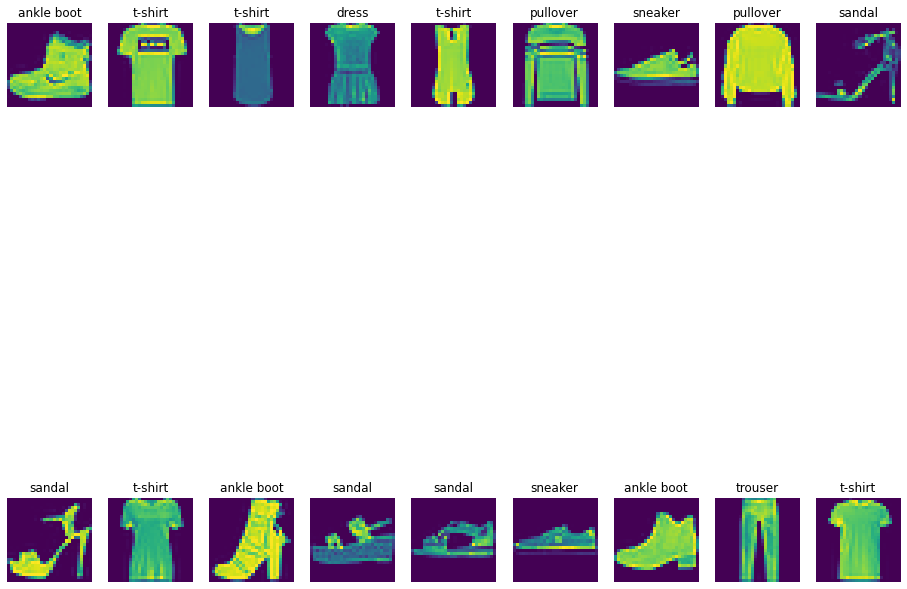

In [25]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

In [26]:
batch_size = 256

def get_dataloader_workers():
    """使用4个进程读取数据"""
    return 4
train_iter = data.DataLoader(mnist_train,batch_size,shuffle = True,
                             num_workers = get_dataloader_workers())

In [27]:
import time
start = time.time()
for X,y in train_iter:
    continue
print(time.time()-start)

2.7099266052246094


In [28]:
# 整合所有部件
def load_data_fashion_mnist(batch_size,resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存去"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0,transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [29]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)              # .dtype() 可以查看数据的类型
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# softmax从零开始实现

In [30]:
import torch
from IPython import display
from d2l import torch as d2l

In [31]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)          #  没有resize大小

In [32]:
num_inputs = 784                   # 输入大小
num_outputs = 10                   # 输出大小/种类数

W = torch.normal(0,0.01,size=(num_inputs, num_outputs),requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

softmax操作：$softmax(X)_{ij} = \frac{exp(x_{ij})}{\sum_kexp(x_{ik})}$
损失函数$cross\_entropy = -log(\hat{y})$

In [33]:
# 定义softmax操作
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1,keepdim = True)   # 在dim=1的方向上求和  ，shape为(batch_size,1)
    return X_exp /partition                   # shape为[batch_size,num_outputs]

# 定义模型
def net(X):
    return softmax(torch.matmul(X.reshape((-1,W.shape[0])),W) + b)    # x.reshape((-1,W.shape[0]))  相当于flatten形式  shapre为[batch_size,W.shape[0]]

# 定义损失函数
def cross_entropy(y_hat,y):
    return -torch.log(y_hat[range(len(y_hat)),y])                      # y为第几种类，种类数目，恰好是y_hat在dim=1上的下标,通过[]符号计算出概率
"""
y_hat[range(len(y_hat)),y]
第一个维度为将所有dim=0的都算上
第二个y为真实值所在的下标
"""

# 计算分类精准
def accuracy(y_hat,y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] >1:             
        y_hat = y_hat.argmax(axis = 1)   # 找下标最大的那个把坐标返回
    cmp = y_hat.type(y.dtype) == y       # 等号表达式从右向左
    return float(cmp.type(y.dtype).sum())    

In [34]:
def evaluate_accuracy(net,data_iter):
    if isinstance(net,torch.nn.Module):
        net.eval()   # 将模型设置为评估模式
    metric = Accumulator(2)
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

In [35]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self,n):
        self.data = [0.0] * n
    
    def add(self,*args):
        self.data = [a + float(b) for a, b in zip(self.data,args)]          # 对应元素相加
        
    def reset(self):                   # reset重新设置
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

In [36]:
# 训练
def train_epoch_ch3(net, train_iter, loss, updater):
    # 将模型设置为训练模式
    if isinstance(net,torch.nn.Module):
        net.train()
    # 训练损失总和，训练准确度总和，样本数
    metric = Accumulator(3)
    for X,y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)              
        l = loss(y_hat,y)           
        if isinstance(updater,torch.optim.Optimizer):
            # 使用pytorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())            # .numel()返回数组元素个数
    # 返回训练损失和训练精度
    return metric[0]/metric[2],metric[1]/metric[2]

In [37]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self,xlabel =None,ylabel=None,legend=None,xlim=None,
                 ylim=None, xscale='linear',yscale='linear',
                 fmts=('-', 'm--','g-','r:'), nrows=1, ncols=1,
                 figsize = (3.5,2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0],xlabel,ylabel,xlim,ylim,xscale,yscale,legend)
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self,x,y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y =[y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y,self.fmts):
            self.axes[0].plot(x,y,fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [38]:
def train_ch3(net,train_iter,test_iter,loss,num_epochs,updater):
    animator = Animator(xlabel="epoch",xlim=[1,num_epochs],ylim=[0.3,0.9],
                        legend = ['train loss', 'train acc','test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net,train_iter,loss,updater)
        test_acc = evaluate_accuracy(net,test_iter)
        animator.add(epoch + 1,train_metrics + (test_acc,))
    train_loss,train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc<=1 and train_acc > 0.7, train_acc
    assert test_acc <=1 and test_acc > 0.7, test_acc

In [39]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W,b],lr,batch_size)

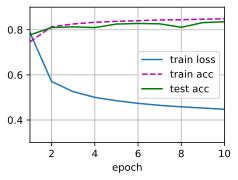

In [40]:
num_epochs = 10
train_ch3(net,train_iter, test_iter, cross_entropy, num_epochs, updater)

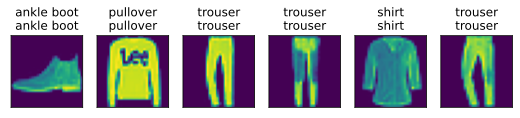

In [40]:
def predict_ch3(net,test_iter,n=6):
    for X,y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues,preds)]
    d2l.show_images(
        X[0:n].reshape((n,28,28)),1,n,titles= titles[0:n])

predict_ch3(net,test_iter)

# softmax简洁实现

In [41]:
import torch
from torch import nn
from d2l import torch as d2l

In [42]:
batch_size = 256
train_iter,test_iter = load_data_fashion_mnist(batch_size)

In [43]:
# PyTorch不会隐式地调整输⼊的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整⽹络输⼊的形状
net = nn.Sequential(nn.Flatten(),nn.Linear(784,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

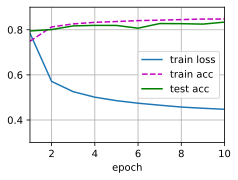

In [44]:
loss = nn.CrossEntropyLoss(reduction='none')  # 损失函数
trainer = torch.optim.SGD(net.parameters(),lr=0.1)  # 优化算法
num_epochs = 10
train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)